In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.tools import diff
from datetime import datetime


In [6]:
df = pd.read_csv(r'dataset/table_AIH_2009_2024_CLEAN.csv', sep=';')

In [7]:
df.groupby(['mes','ano'], observed=False).agg({'partos_e_nascimentos_qtd': 'sum'}).reset_index()

,mes,ano,partos_e_nascimentos_qtd
0,1,2009,105424.0
1,1,2010,103943.0
2,1,2011,98951.0
3,1,2012,92914.0
4,1,2013,94223.0
...,...,...,...
177,12,2019,80365.0
178,12,2020,75730.0
179,12,2021,78142.0
180,12,2022,75175.0


In [8]:
df['data'] = list(map(lambda x,y: "{}-{}".format(x,y), df['ano'], df['mes']))

In [9]:
def convert_to_datetime(data):
    return datetime.strptime(data, format("%Y-%m"))

In [10]:
df['time'] = list(map(lambda x: convert_to_datetime(x), df['data']))

In [11]:
df_st = df.groupby(['time']).agg({'partos_e_nascimentos_qtd': 'sum',
                                  'partos_e_nascimentos_val':'sum',
                                  'cirurgias_obstetricas_qtd': 'sum',
                                  'cirurgias_obstetricas_val': 'sum'})

In [15]:
df_st.head()

,partos_e_nascimentos_qtd,partos_e_nascimentos_val,cirurgias_obstetricas_qtd,cirurgias_obstetricas_val
time,,,,
2009-01-01,105424.0,56176411.81,70826.0,34960984.60
2009-02-01,102933.0,54825506.19,69128.0,34439919.89
2009-03-01,117114.0,62399264.22,77726.0,38846455.60
2009-04-01,113382.0,60340947.92,75718.0,37832404.45
2009-05-01,114401.0,61212225.34,76650.0,38719927.20


In [12]:
df_st = df_st['2009-01-01':'2023-12-01']

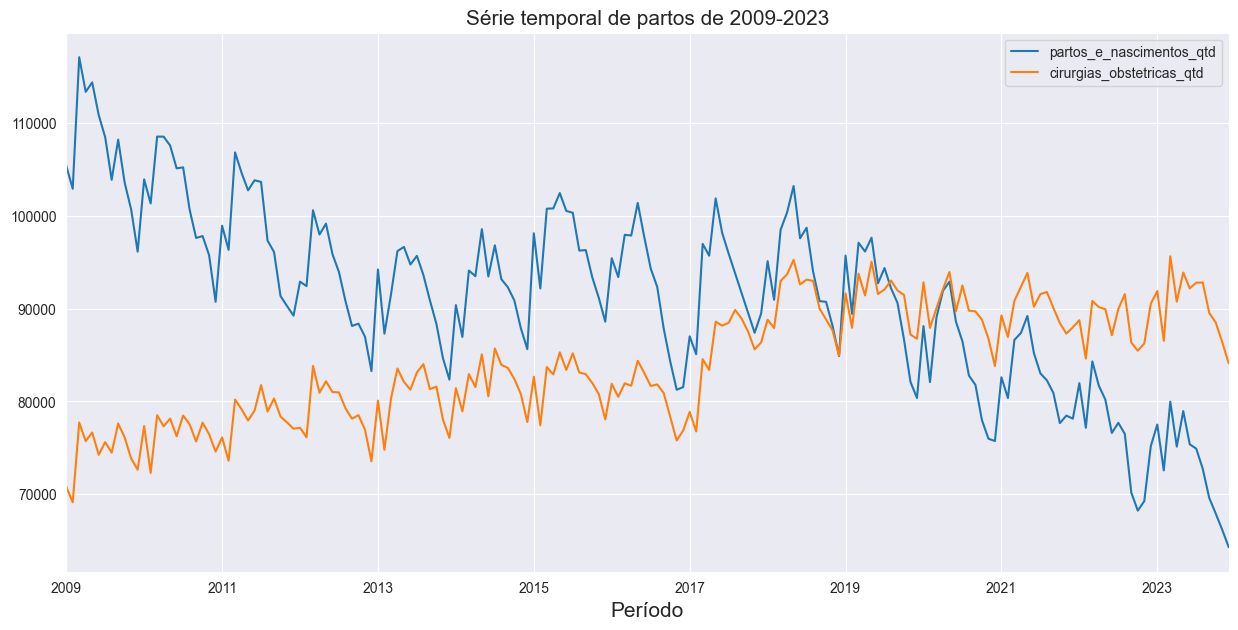

In [16]:
df_st[['partos_e_nascimentos_qtd', 'cirurgias_obstetricas_qtd',]].plot(figsize=(15,7), legend=True)
plt.xlabel('Período',size=15)
plt.title('Série temporal de partos de 2009-2023',size=15)
plt.show()

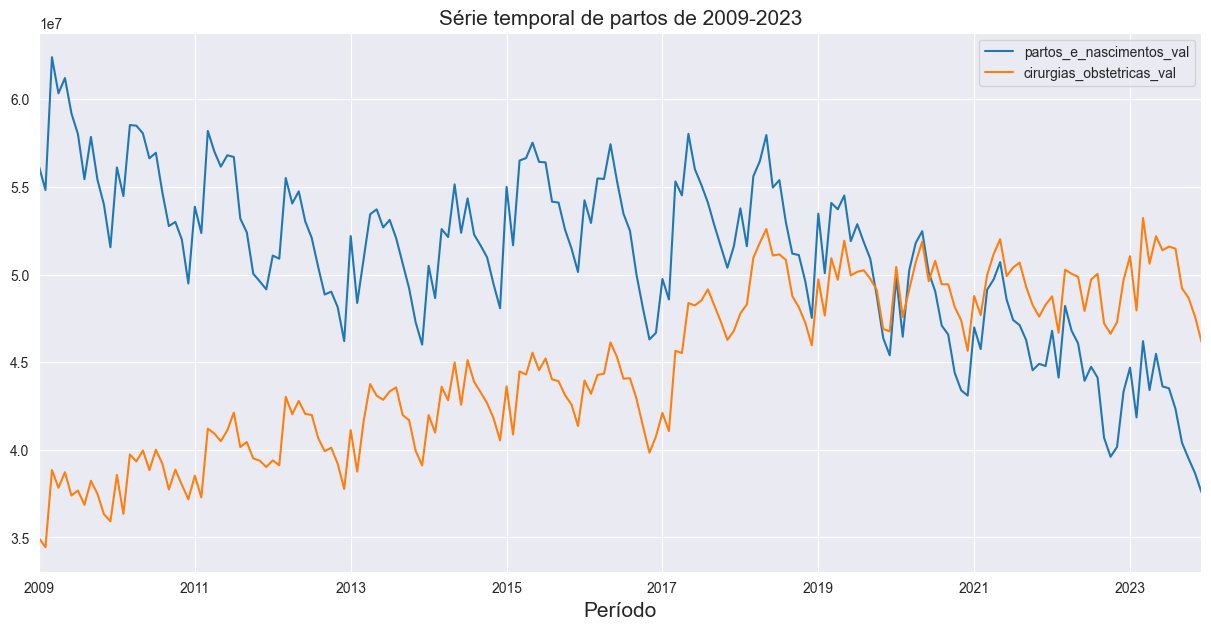

In [17]:
df_st[['partos_e_nascimentos_val', 'cirurgias_obstetricas_val',]].plot(figsize=(15,7), legend=True)
plt.xlabel('Período',size=15)
plt.title('Série temporal de partos de 2009-2023',size=15)
plt.show()

In [31]:
df_st[['partos_e_nascimentos_qtd', 'cirurgias_obstetricas_qtd']].isnull().sum()

partos_e_nascimentos_qtd     0
cirurgias_obstetricas_qtd    0
dtype: int64

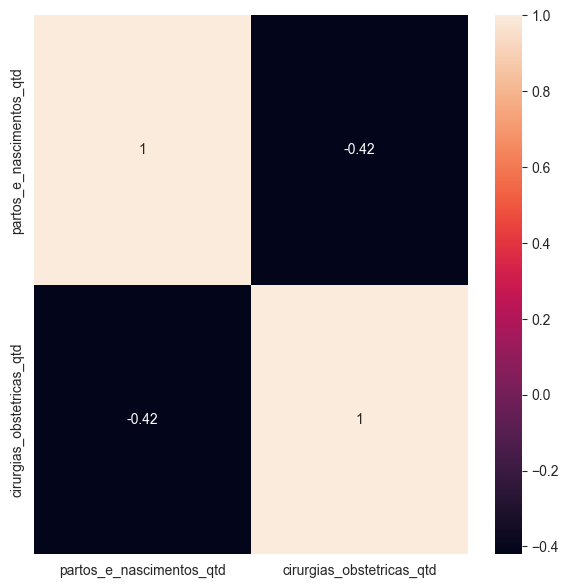

In [21]:
plt.figure(figsize=(7,7))
correlacao = df_st[['partos_e_nascimentos_qtd', 'cirurgias_obstetricas_qtd']].corr()
sns.heatmap(correlacao, annot = True);

In [45]:
pct = df_st[['partos_e_nascimentos_qtd', 'cirurgias_obstetricas_qtd']].pct_change().dropna()

In [57]:
from statsmodels.tsa.stattools import grangercausalitytests

gc_res =  grangercausalitytests(pct, 4)

C:\Users\lino.pereira\PycharmProjects\desafio_ciencia_dados_2\venv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [55]:
for k,v in gc_res.items():
    print(k, v)

1 ({'ssr_ftest': (24.26545469519615, 1.9335604008015942e-06, 175.0, 1), 'ssr_chi2test': (24.68143391854237, 6.763257599539995e-07, 1), 'lrtest': (23.113639104438562, 1.5270366175855021e-06, 1), 'params_ftest': (24.26545469519613, 1.9335604008016383e-06, 175.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000024A085B7990>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000024A0AC30210>, array([[0., 1., 0.]])])
2 ({'ssr_ftest': (26.715714776827763, 7.874127395244671e-11, 172.0, 2), 'ssr_chi2test': (54.984668784866436, 1.1487641628050003e-12, 2), 'lrtest': (47.882315073056134, 4.0039384387869084e-11, 2), 'params_ftest': (26.71571477682776, 7.874127395244756e-11, 172.0, 2.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000024A07995C50>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000024A085743D0>, array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])])
3 ({

In [37]:
# Função para testar estacionariedade com o teste ADF
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1] <= 0.05  # Retorna True se a série é estacionária (p-value <= 0.05)

In [32]:
from statsmodels.tsa.stattools import adfuller

print('Estatística do teste Dickey-Fuller:',adfuller(df_st['cirurgias_obstetricas_qtd'])[0])
print('P-valor:',adfuller(df_st['cirurgias_obstetricas_qtd'])[1])
print('Defasagens usadas no teste:',adfuller(df_st['cirurgias_obstetricas_qtd'])[2])
print('Observações usadas:',adfuller(df_st['cirurgias_obstetricas_qtd'])[3])
print('Valores críticos:',adfuller(df_st['cirurgias_obstetricas_qtd'])[4])

Estatística do teste Dickey-Fuller: -1.6354969740033178
P-valor: 0.4646147103367285
Defasagens usadas no teste: 14
Observações usadas: 165
Valores críticos: {'1%': -3.470616369591229, '5%': -2.8792214018977655, '10%': -2.57619681359045}


###### Não é estacionária

Text(0.5, 1.0, 'Séries de partos e cirúrgias obstétricas diferenciadas uma vez')

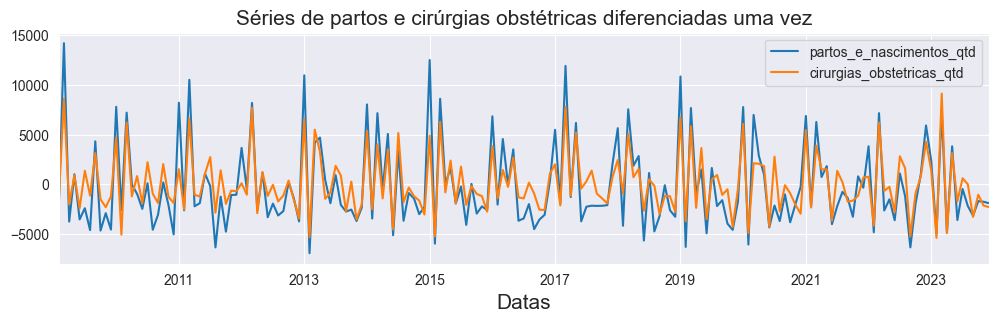

In [38]:
#f=diferenciando as séries apenas uma vez
df_diff=diff(df_st[['partos_e_nascimentos_qtd', 'cirurgias_obstetricas_qtd']],k_diff=1)
df_diff.plot(figsize=(12,3))
plt.xlabel('Datas',size=15)
plt.title("Séries de partos e cirúrgias obstétricas diferenciadas uma vez",size=15)

Teste ADF na série original:
ADF Statistic: -1.6354969740033178
p-value: 0.4646147103367285
Critical Values:
   1%: -3.470616369591229
   5%: -2.8792214018977655
   10%: -2.57619681359045
ADF Statistic: -1.6354969740033178
p-value: 0.4646147103367285
Critical Values:
   1%: -3.470616369591229
   5%: -2.8792214018977655
   10%: -2.57619681359045
1


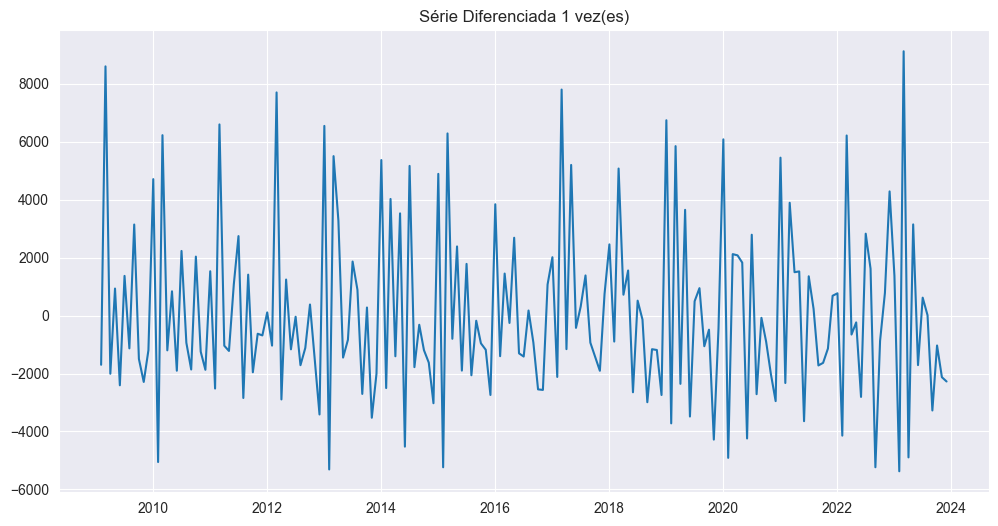

ADF Statistic: -2.6767852182255165
p-value: 0.0781423078169548
Critical Values:
   1%: -3.470616369591229
   5%: -2.8792214018977655
   10%: -2.57619681359045
2


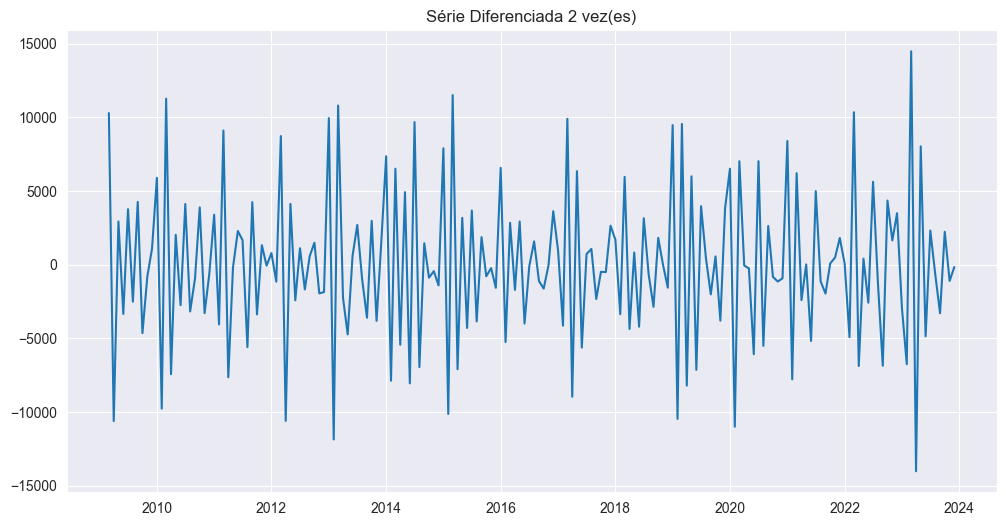

ADF Statistic: -9.726841688698231
p-value: 9.225770795444533e-17
Critical Values:
   1%: -3.470616369591229
   5%: -2.8792214018977655
   10%: -2.57619681359045
A série se tornou estacionária após 2 diferenciações.


In [41]:
print('Teste ADF na série original:')
adf_test(df_st['cirurgias_obstetricas_qtd'])

# Diferenciação até a série se tornar estacionária
d = 0
serie = df_st['cirurgias_obstetricas_qtd']
while not adf_test(serie):
    d += 1
    print(d)
    serie = serie.diff().dropna()
    plt.figure(figsize=(12, 6))
    plt.plot(serie)
    plt.title(f'Série Diferenciada {d} vez(es)')
    plt.show()

print(f'A série se tornou estacionária após {d} diferenciações.')

Teste ADF na série original:
ADF Statistic: -0.2014761075527565
p-value: 0.9383454404729212
Critical Values:
   1%: -3.470616369591229
   5%: -2.8792214018977655
   10%: -2.57619681359045
ADF Statistic: -0.2014761075527565
p-value: 0.9383454404729212
Critical Values:
   1%: -3.470616369591229
   5%: -2.8792214018977655
   10%: -2.57619681359045
1


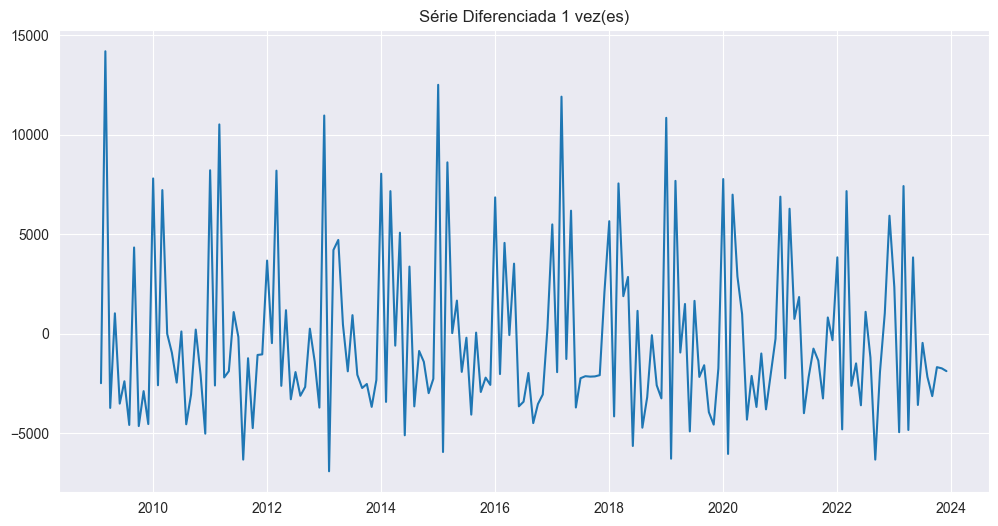

ADF Statistic: -2.859405150517863
p-value: 0.050276374999203836
Critical Values:
   1%: -3.47086589632514
   5%: -2.879330279087651
   10%: -2.57625492712671
2


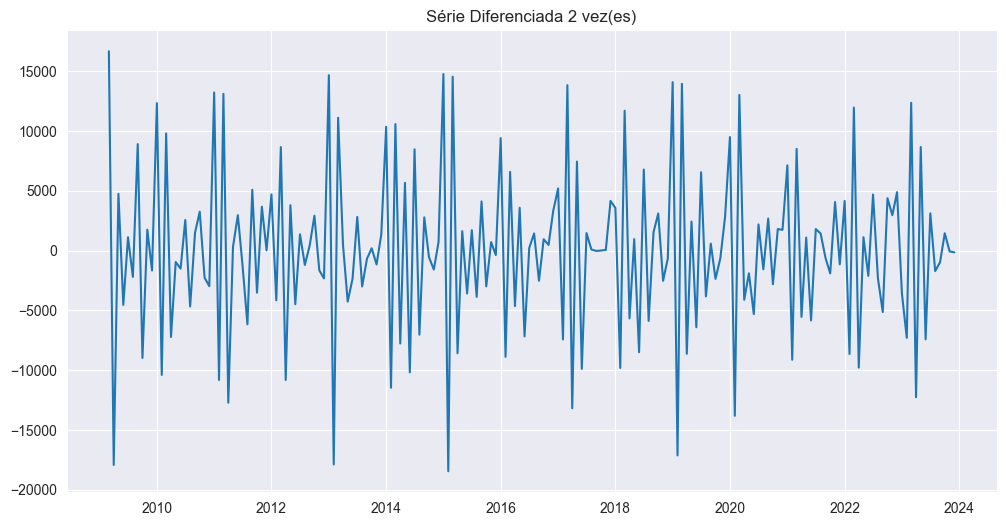

ADF Statistic: -10.240306074953983
p-value: 4.7687243237441935e-18
Critical Values:
   1%: -3.470616369591229
   5%: -2.8792214018977655
   10%: -2.57619681359045
A série se tornou estacionária após 2 diferenciações.


In [42]:
print('Teste ADF na série original:')
adf_test(df_st['partos_e_nascimentos_qtd'])

# Diferenciação até a série se tornar estacionária
d = 0
serie = df_st['partos_e_nascimentos_qtd']
while not adf_test(serie):
    d += 1
    print(d)
    serie = serie.diff().dropna()
    plt.figure(figsize=(12, 6))
    plt.plot(serie)
    plt.title(f'Série Diferenciada {d} vez(es)')
    plt.show()

print(f'A série se tornou estacionária após {d} diferenciações.')

In [43]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,0,1)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_st[['partos_e_nascimentos_qtd', 'cirurgias_obstetricas_qtd']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
partos_e_nascimentos_qtd ::  31.34     > 15.4943   =>   True
cirurgias_obstetricas_qtd ::  4.6       > 3.8415    =>   True
